# Import Packages

In [1]:
import cv2
import copy
import math
import _pickle as cPickle
import scipy.io
import scipy as sp
import numpy as np
from time import time
from PIL import Image

import utils.plotFunctions as pf
import utils.helperFunctions as hf
from utils.lcaFunctions import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion()

from sklearn.metrics import mean_squared_error
from sklearn.decomposition import sparse_encode
from sklearn.decomposition import MiniBatchDictionaryLearning

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, models

# Generate Dictionary and Sparse Codes

## Extract data

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.0, 0.0, 0.0), (1.0, 1.0, 1.0))
    ])

batch_size = 4

trainset =  torchvision.datasets.CIFAR10(root='./data/data_train', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=0)

Files already downloaded and verified


In [3]:
def preprocess_cifar10(dataiter, classes):
    all_patches_grouped = []
    all_labels_grouped = []
    all_images_grouped = []
    all_patches_flattened = []
    all_labels_flattened = []
    all_images_flattened = []
    patch_size = 8
    for j in range(len(dataiter)):
        images, labels = dataiter.next()
        for i in range(len(images)):
            im = np.transpose(images[i].numpy(), (1, 2, 0))
            all_images_grouped.append(im)
            all_labels_grouped.append(classes[labels[i]])
            patches = []
            for px in range(int(im.shape[0]/patch_size)):
                for py in range(int(im.shape[0]/patch_size)):
                    patches.append(im[px*patch_size:(px*patch_size)+patch_size, py*patch_size:(py*patch_size)+patch_size, :])
                    all_patches_flattened.append(im[px*patch_size:(px*patch_size)+patch_size, py*patch_size:(py*patch_size)+patch_size, :])
                    all_images_flattened.append(im)
                    all_labels_flattened.append(classes[labels[i]])
            all_patches_grouped.append(patches)
        #     plt.figure(figsize = (4, 4))
        #     for i, patch in enumerate(patches):
        #         plt.subplot(4, 4, i + 1)
        #         plt.imshow(patch)
        #     plt.subplots_adjust(0.05)
    all_patches = np.array(all_patches_grouped)
    all_labels = np.array(all_labels_grouped)
    all_images = np.array(all_images_grouped)
    patches_flattened = np.array(all_patches_flattened)
    labels_flattened = np.array(all_labels_flattened)
    images_flattened = np.array(all_images_flattened)
    
    return all_patches, all_labels, all_images, patches_flattened, labels_flattened, images_flattened

def pickle_dump(fn, data):
    with open(fn, "wb") as output_file:
        cPickle.dump(data, output_file)
        
def pickle_load(fn):
    with open(fn, "rb") as input_file:
        data = cPickle.load(input_file)
    return data

## Load CIFAR10 patches

In [4]:
classes = trainset.classes
grouped_patches, grouped_labels, grouped_images, patches, labels, images = preprocess_cifar10(iter(trainloader), classes)
print(grouped_patches.shape)
print(grouped_labels.shape)
print(grouped_images.shape)
print(patches.shape)
print(labels.shape)
print(images.shape)
pickle_dump('grouped_patches.pkl', grouped_patches)
pickle_dump('grouped_labels.pkl', grouped_labels)
pickle_dump('grouped_images.pkl', grouped_images)
pickle_dump('patches.pkl', patches)
pickle_dump('labels.pkl', labels)
pickle_dump('images.pkl', images)

(50000, 16, 8, 8, 3)
(50000,)
(50000, 32, 32, 3)
(800000, 8, 8, 3)
(800000,)
(800000, 32, 32, 3)


## Load Dictionary

In [5]:
def load_dictionary(fn, size):
    mat = scipy.io.loadmat(fn)
    dic = torch.from_numpy((mat['weight_vals'].astype(np.float32)))
    dic = dic.float() /1
    dic = dic.numpy()
    print(dic.shape)
    dic_flattened = dic.reshape(192, size)
    pickle_dump('dic_{}.pkl'.format(size), dic_flattened)
    return dic_flattened
dic128 = load_dictionary('newfilters50k_nomom.mat', 128)
dic256 = load_dictionary('dic256.mat', 256)
dic512 = load_dictionary('dic512.mat', 512)

(8, 8, 3, 128)
(8, 8, 3, 256)
(8, 8, 3, 512)


### LCA

In [6]:
# Sparse Coding hyperparameters
lambdav = 0.1 # Value set by myself
batchSize = 50  # Number of samples to use in a single weight update
eta = 0.1  # Learning rate
numTrials = 2500  # Number of weight update steps

# Inference hyperparameters
tau = 100 # LCA update time constant
numInferenceSteps = 400 # Number of iterations to run LCA

# Plot display parameters
displayStatsInterval = 50  # How often to update the stats plots

# Dataset specific hyperparameters
numInputs = 64
numOutputs = 128 # Number of neurons
numDataPoints = 64000

#Functions from Berkley, Neural Computation, lab 4
def threshold(u, lambdav):                                                                                                                                                                                                          
    a = np.abs(u) - lambdav                                                                                                                                                                                                            
    a[np.where(a<0)] = 0          
    a = np.sign(u) * a    
    a[np.where(a<0)] = 0 #Non-negative only
    return a

def inference(dataBatch, phi, tau, lambdav, numInferenceSteps):
    u_history = [] # List of membrane potentials recorded at each integer 2^i
    
    b = phi.T @ dataBatch # Driving input
    gramian = phi.T @ phi - np.identity(int(phi.shape[1])) # Explaining away matrix
    u = np.zeros_like(b) # Initialize membrane potentials to 0
    
    for step in range(numInferenceSteps):
        a = threshold(u, lambdav) # Activity vector contains thresholded membrane potentials
        du = b - u - (gramian @ a)
        u += (1.0 / tau) * du # Update membrane potentials using time constant
        
        # If step is a power of 2 (2, 4, 6... 256... numInferenceSteps), record membrane potentials
        if step != 0 and (math.ceil(np.log2(step)) == math.floor(np.log2(step))) or step == (numInferenceSteps - 1): 
            #print("Recording membrane potentials at step: ", step)
            u_history.append(u)
            
    return u_history, threshold(u, lambdav)

def weightUpdate(phi, dataBatch, activity, learningRate):
    dataBatchReconstruction = phi @ activity
    reconstructionError = dataBatch - dataBatchReconstruction
    dPhi = reconstructionError @ activity.T # Weight update rule (dE/dPhi)
    phi = phi + learningRate * dPhi # Scale weight update by learning rate
    return (phi, reconstructionError)


# Computes dictionary with LCA
# Function from Berkley, Neural Computation, lab 4
def trainModel(dataset):
    t0 = time()
    # Plotting
    sumPercentNonZero, sumEnergy, sumReconstructionQualitySNR = 0, 0, 0
    statsFig, statsAxes = pf.plotStats(numTrials)
    
    # Initialize phi weight matrix randomly
    phi = hf.l2Norm((np.random.randn(numInputs, numOutputs) * 2) - 1)
    
    # Sparse coding with LCA
    for trial in range(numTrials):
        # Make batch of random images
        dataBatch = np.zeros((numInputs, batchSize))
        for batchNum in range(batchSize):
            dataBatch[:, batchNum] = dataset[np.random.randint(dataset.shape[0])]
            
        # Compute sparse code for batch of data samples
        _, activity = inference(dataBatch, phi, tau, lambdav, numInferenceSteps)

        # Update weights using inferred sparse activity
        learningRate = eta / batchSize
        (phi, reconstructionError) = weightUpdate(phi, dataBatch, activity, learningRate)

        # Renormalize phi matrix
        phi = hf.l2Norm(phi)

        # Record stats for plotting
        percentNonZero, energy, reconstructionQualitySNR = (
            hf.computePlotStats(activity, reconstructionError, lambdav))
        sumPercentNonZero += percentNonZero
        sumEnergy += energy
        sumReconstructionQualitySNR += reconstructionQualitySNR

        if trial and trial % displayStatsInterval == 0:
            avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR = (
                sumEnergy/ displayStatsInterval, sumPercentNonZero / displayStatsInterval, 
                sumReconstructionQualitySNR / displayStatsInterval)
            pf.updateStats(statsFig, statsAxes, trial, avgEnergy, avgPercentNonZero, avgReconstructionQualitySNR)
            sumPercentNonZero = 0
            sumEnergy = 0
            sumReconstructionQualitySNR = 0
    dt = time() - t0    
    print("Dictionary learned in: ", dt)
            
    return phi

In [7]:
#Training set used to learn dictionaries
def infer_sparse_codes(fn, patches, dic):
    patches = patches.reshape(patches.shape[0], 192)
    t0 = time()
    print("Inferring LCA sparse code of training with complete (128 element) dictionary...")
    uhist, codes = inference(patches.T, dic, tau, lambdav, numInferenceSteps) # cifar_train.T because shape=(numInputs, batchSize) 
    dt = time() - t0
    print('done in %.2fs.' % dt)
    codes = codes.T
    # np.save(fn, codes)
    pickle_dump(fn, codes)
    return codes

def reconstruct_codes(codes, dic, patches):
    recon = np.dot(codes, dic.T)
    recon = recon.reshape(len(codes), 8 , 8, 3)
    patches_true = patches.reshape(patches.shape[0], 8, 8, 3)

    # Generate plot
    f, axarr = plt.subplots(2, 10)
    f.set_size_inches(20, 5)
    for i in range(10):
        axarr[0,i].imshow((recon[i] + 0.5).astype('float64'))
        axarr[1,i].imshow((patches_true[i]+0.5).astype('float64'))
    plt.suptitle("First 10 cifar_patch reconstructions\n(Complete, 128 element dictionary)")
    plt.show()
    # plt.savefig('cifar_patch_reconstruction.png')
    plt.figure(figsize = (4, 4))
    for i, patch in enumerate(recon[:16,:,:,:]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((patch+0.5).astype('float64'))
    plt.subplots_adjust(0.05)
    plt.figure(figsize = (4, 4))
    for i, patch in enumerate(patches_true[:16,:,:,:]):
        plt.subplot(4, 4, i + 1)
        plt.imshow((patch+0.5).astype('float64'))
    plt.subplots_adjust(0.05)

## Reconstruct sparse codes

Inferring LCA sparse code of training with complete (128 element) dictionary...
done in 1.76s.
Inferring LCA sparse code of training with complete (128 element) dictionary...
done in 3.45s.
Inferring LCA sparse code of training with complete (128 element) dictionary...
done in 7.79s.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

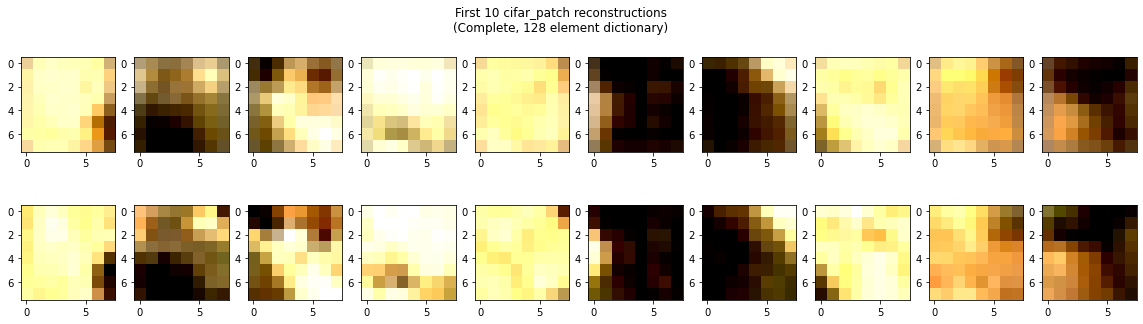

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

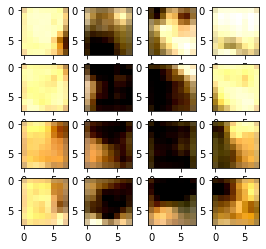

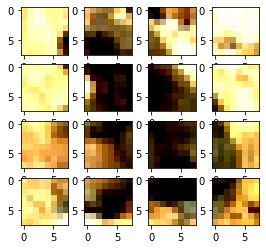

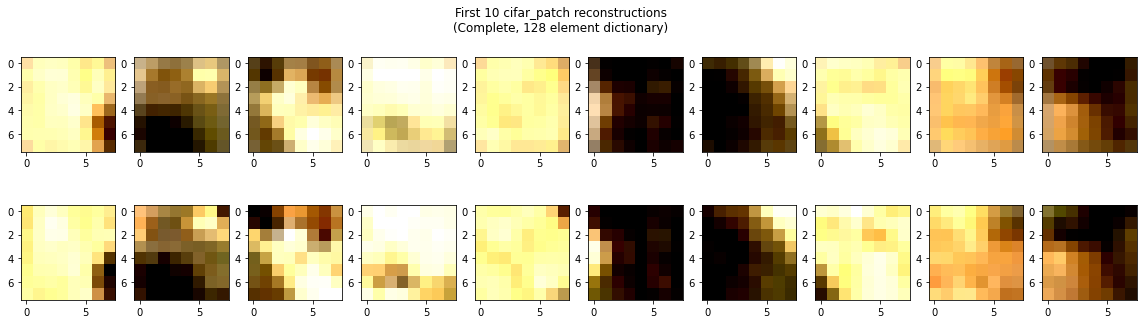

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

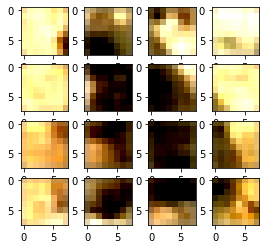

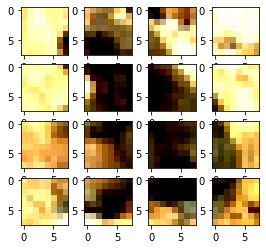

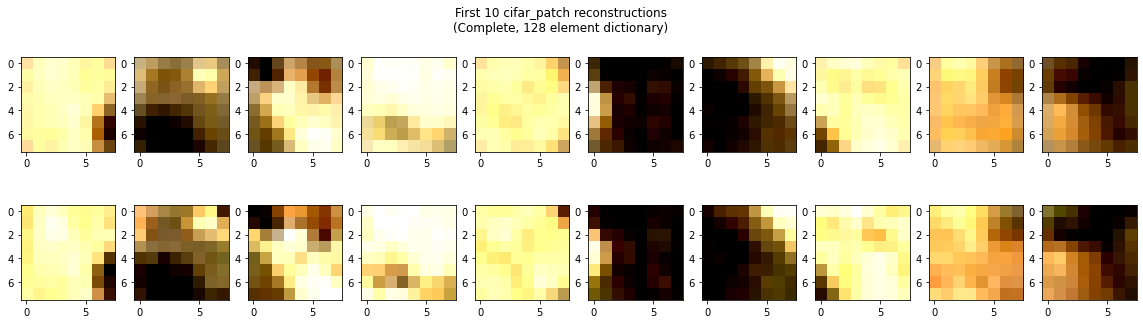

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

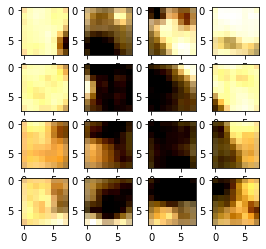

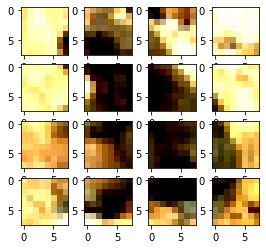

In [8]:
###Just do 1000 to go fast
patches = patches[:1000, :]

codes128 = infer_sparse_codes('codes128_1000.pkl', patches, dic128)
codes256 = infer_sparse_codes('codes256_1000.pkl', patches, dic256)
codes512 = infer_sparse_codes('codes512_1000.pkl', patches, dic512)

reconstruct_codes(codes128, dic128, patches)
reconstruct_codes(codes256, dic256, patches)
reconstruct_codes(codes512, dic512, patches)